## Data Preparation for Flood Impact Prediction (FIP)
The description would be updated...

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer
import matplotlib.pyplot as plt
from functools import reduce
import fhv
pd.options.mode.chained_assignment = None

### Population

The [Worldpop's 100m population data](https://www.worldpop.org/geodata/summary?id=5589) is downscaled to 30m by "QGIS > Raster > Align Rasters" to be consistent with inundation maps. In this process, the values are rescaled according to the resolution change, which is the option of the function.
The total population in data was 158,150,540. This is rescaled to 159,670,593 (WorldBank, 2017).
The final population raster has decuple values (10 times larger than original values) to avoid losing populated areas in integer (uint16) format.

In [2]:
# Inithial downscaled file is processed by QGIS
if False:    # This is done already
    with rasterio.open('./data/ppp_30m.tif') as src:    # This is done by QGIS
        data = src.read(1)
        data[data<0] = 0                     # Since the nodata value (-99999.0) is also rescaled
        data = data/data.sum()*159679593     # Scale to WorldBank's population
        data = np.round(data*10).astype(rasterio.uint16)
        profile = src.profile.copy()
        profile.update(
            nodata=0,
            dtype=rasterio.uint16,
            compress='lzw')
        out_fn = './data/bgd_ppp_2017_30m_decuple.tif'       # This file is the reference of all rasters
        with rasterio.open(out_fn, 'w', **profile) as dst:
            dst.write_band(1, data)
        print('%s is saved.' % out_fn) 

### Convert a shapefile of the union to raster format
Here we convert administrative boundary polygons (shapefile) to raster format. Specifically, we burn (convert) the ID number of unions in 30m spatial resolution. The shapefile of administrative boundaries is obtained from [OCHA-HDX](https://data.humdata.org/dataset/administrative-boundaries-of-bangladesh-as-of-2015).

In [106]:
# District
shp_fn = './data/admin_boundary/bgd_admbnda_adm2_bbs_20180410.shp'
gdf = gpd.read_file(shp_fn)
shp_district = gdf[gdf.columns[[3,2,8,7,-1]]].sort_values('ADM2_PCODE').reset_index(drop=True)
# Upazila
shp_fn = './data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp'
gdf = gpd.read_file(shp_fn)
shp_upazila = gdf[gdf.columns[[3,2,8,7,-1]]].sort_values('ADM3_PCODE').reset_index(drop=True)
# Union
shp_fn = './data/admin_boundary/bgd_admbnda_adm4_bbs_20180410.shp'
gdf = gpd.read_file(shp_fn)
shp_union = gdf[gdf.columns[[3,2,8,7,-1]]].sort_values('ADM4_PCODE').reset_index(drop=True)
if False:
    # Save template shapfiles
    shp_district_fn = './data/adm_district.shp'
    shp_district.to_file(shp_district_fn)
    print('%s is saved..' % shp_district_fn)
    shp_upazila_fn = './data/adm_upazila.shp'
    shp_upazila.to_file(shp_upazila_fn)
    print('%s is saved..' % shp_upazila_fn)
    shp_union_fn = './data/adm_union.shp'
    shp_union.to_file(shp_union_fn)
    print('%s is saved..' % shp_union_fn)
    
# Convert a Union shapefile to raster
rst_fn = './data/bgd_ppp_2017_30m_decuple.tif'
out_fn = './data/unid_30m.tif'
# fhv.ConvertShapeToRaster(shp_fn, rst_fn, out_fn, fieldname='ADM4_PCODE', out_dtype=rasterio.int32)

# Validate the number of unions (validated)
if False:
    # Number of unions from shapefile (5160)
    nUnion1 = np.unique(gpd.read_file(shp_fn)['ADM4_PCODE']).shape[0]
    # Number of unions from raster (5160)
    nUnion2 = np.unique(rasterio.open(out_fn).read(1)).shape[0] - 1
    assert nUnion1 == nUnion2, 'the numbers of unions are different'

# Union ID table
uidList = shp_union['ADM4_PCODE'].astype(rasterio.int32)

# List indexes of cells per union (This will make the aggregation easier)
uidx_fn = './data/uidx.npz'
if not os.path.exists(uidx_fn):
    start_time = time.time()
    idun = rasterio.open('./data/unid_30m.tif').read(1)                 # Union ID
    uidx = []
    for i,uid in uidList.iteritems():
        uidx.append(np.ravel_multi_index(np.where(idun==uid), idun.shape))
        print(i)
    # Save to numpy file
    np.savez_compressed('./data/uidx', uidx=uidx)
    print('elapsed_time: %ds' % (time.time() - start_time))
else:
    uidx = np.load(uidx_fn, allow_pickle=True)['uidx']

### Inundated areas from Sentinel-1 
The 2017 flood inundation maps are processed and produced by ICIMOD (Mr. Kabir Uddin), for example, [August composite inundation](http://rds.icimod.org/Home/DataDetail?metadataId=34492). Daily inundations are also generated for Jul-29, Aug-12, Aug-14, and Aug-24. Here we calculate inundated area (%) of each Union.</br>There was a resolution issue for August and 

In [6]:
# ICIMOD's inundations
# The monthly composite inundation maps (April, June, August) are exported as GeoTiff format 
# using "QGIS>Export>Save as"
ref_path = './data/bgd_ppp_2017_30m_decuple.tif'
in_path = './data/flood2017aug/Flood_Apr.tif'
out_path = './data/flood_apr_30m.tif'
# fhv.ReprojectToReference(in_path,ref_path,out_path,rasterio.uint8,0)
in_path = './data/flood2017aug/Flood_Jun.tif'
out_path = './data/flood_jun_30m.tif'
# fhv.ReprojectToReference(in_path,ref_path,out_path,rasterio.uint8,0)
in_path = './data/flood2017aug/Flood_Aug.tif'
out_path = './data/flood_aug_30m.tif'
# fhv.ReprojectToReference(in_path,ref_path,out_path,rasterio.uint8,0)

# Daily inundation maps
in_path = './data/flood2017aug/Flood data of Bangladesh on July 29, 2017/data/bd_flood_29_jul.img'
out_path = './data/flood_jul29_30m.tif'
# fhv.ReprojectToReference(in_path,ref_path,out_path,rasterio.uint8,0)
in_path = './data/flood2017aug/Flood data of Bangladesh on Aug 12, 2017/data/bd_flood_12_aug.img'
out_path = './data/flood_aug12_30m.tif'
# fhv.ReprojectToReference(in_path,ref_path,out_path,rasterio.uint8,0)
in_path = './data/flood2017aug/Flood data of Bangladesh on Aug 15, 2017/data/bd_flood_15_aug.img'
out_path = './data/flood_aug15_30m.tif'
# fhv.ReprojectToReference(in_path,ref_path,out_path,rasterio.uint8,0)
in_path = './data/flood2017aug/Flood data of Bangladesh on Aug 24, 2017/data/bd_flood_24_aug.img'
out_path = './data/flood_aug24_30m.tif'
# fhv.ReprojectToReference(in_path,ref_path,out_path,rasterio.uint8,0)

### Composite inundation for 2017 August event
Here, we make a composite inundation map which can represent overall inundated areas from the 2017 flood event.  
The values of the composite maps represent: 1 (Perennial waterbodies), 2 (Flood inundation area), and 3 (Other).

In [7]:
# List of inundation maps
mon_path = ['./data/flood_apr_30m.tif', './data/flood_jun_30m.tif', './data/flood_aug_30m.tif']
day_path = ['./data/flood_jul29_30m.tif', './data/flood_aug12_30m.tif', './data/flood_aug15_30m.tif', './data/flood_aug24_30m.tif']
with rasterio.open(mon_path[0]) as src:
    data = src.read(1)
    inun = np.zeros(data.shape, rasterio.uint8)
    profile = src.profile.copy()

# Make a composite inundation
# - Inundated area from daily maps
for path in day_path:
    with rasterio.open(path) as src:
        data = src.read(1)
        inun[data == 1] = 2    
# - Inundated area from monthly maps
for path in mon_path:
    with rasterio.open(path) as src:
        data = src.read(1)
        inun[data == 2] = 2
# - Perennial water from monthly maps
for path in mon_path:
    with rasterio.open(path) as src:
        data = src.read(1)
        inun[data == 1] = 1

# Generate a new raster file
out_fn = './data/bgd_inun_30m.tif'
if not os.path.exists(out_fn):
    with rasterio.open(out_fn, 'w+', **profile) as dst:
        dst.write_band(1, inun)
        print('%s is saved.' % out_fn)

### Number of people affected by 2017 flood
The affected people is assessed by counting population per pixel (PPP) in the flooded areas.

In [35]:
# Load data
inun = rasterio.open('./data/bgd_inun_30m.tif').read(1).flatten()   # 1 (Perennial waterbodies), 2 (Flood inundation area)
popu = rasterio.open('./data/bgd_ppp_2017_30m_decuple.tif').read(1).flatten()

# Affected population per union
inunPopu =  popu.copy()
inunPopu[inun == 0] = 0
inunPopu = inunPopu.flatten()
# Counting population
totlPopu = np.zeros(uidList.shape)
afftPopu = np.zeros(uidList.shape)
totlCell = [len(udx) for udx in uidx]
inunCell = np.zeros(uidList.shape)
for i, uid in uidList.iteritems():
    totlPopu[i] = popu[uidx[i]].sum()
    afftPopu[i] = inunPopu[uidx[i]].sum()
    inunCell[i] = np.isin(inun[uidx[i]], [1,2]).sum()
# Rescale and Add one to avoid numeric errors
totlPopu = (totlPopu+1)/10
afftPopu = (afftPopu+1)/10

In [107]:
# Generate a Union dataframe
impact4 = shp_union.drop('geometry', axis=1)
impact4['TOTAL_PPL'], impact4['AFFECTED_PPL'] = totlPopu, afftPopu
impact4['AFFECTED_PPL_RATIO'] = afftPopu/totlPopu
impact4['TOTAL_CELL'], impact4['FLOODED_CELL'] = totlCell, inunCell
impact4['FLOODED_CELL_RATIO'] = inunCell/totlCell
# Aggregate to Upazila level
todist = ['TOTAL_PPL','AFFECTED_PPL','TOTAL_CELL','FLOODED_CELL']
impact3 = impact4.groupby(['ADM3_PCODE', 'ADM3_EN'])[todist].sum()
impact3['AFFECTED_PPL_RATIO'] = impact3['AFFECTED_PPL']/impact3['TOTAL_PPL']
impact3['FLOODED_CELL_RATIO'] = impact3['FLOODED_CELL']/impact3['TOTAL_CELL']
impact3['ADM2_PCODE'], impact3['ADM2_EN'] = shp_upazila['ADM2_PCODE'].values, shp_upazila['ADM2_EN'].values
# Aggregate to District level
todist = ['TOTAL_PPL','AFFECTED_PPL','TOTAL_CELL','FLOODED_CELL']
impact2 = impact3.groupby(['ADM2_PCODE', 'ADM2_EN'])[todist].sum()
impact2['AFFECTED_PPL_RATIO'] = impact2['AFFECTED_PPL']/impact2['TOTAL_PPL']
impact2['FLOODED_CELL_RATIO'] = impact2['FLOODED_CELL']/impact2['TOTAL_CELL']
impact2['ADM1_PCODE'], impact2['ADM1_EN'] = shp_district['ADM1_PCODE'].values, shp_district['ADM1_EN'].values

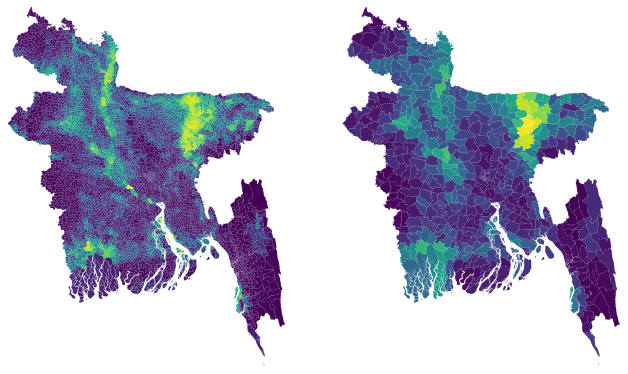

In [129]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

map_union = shp_union.merge(impact4, on='ADM4_PCODE')
map_upazila = shp_upazila.merge(impact3['AFFECTED_PPL_RATIO'], on='ADM3_PCODE')
map_district = shp_district.merge(impact2['AFFECTED_PPL_RATIO'], on='ADM2_PCODE')
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

fig, axes = plt.subplots(1,2,figsize=(11,9), facecolor='w')
# divider = make_axes_locatable(fig)
# cax = divider.append_axes("right", size="5%", pad=0.1)
ax = axes[0]
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
map_union.plot(column='AFFECTED_PPL_RATIO', ax=ax, legend=True, cax=cax)
ax = axes[1]
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
map_upazila.plot(column='AFFECTED_PPL_RATIO', ax=ax, legend=True, cax=cax)





# map_district.plot(column='AFFECTED_PPL_RATIO', ax=ax[1], legend=True, cax=cax)


In [9]:
# Mapping


,,TOTAL_PPL,AFFECTED_PPL,TOTAL_CELL,FLOODED_CELL,AFFECTED_PPL_RATIO,FLOODED_CELL_RATIO
ADM3_PCODE,ADM3_EN,,,,,,
100409,Amtali,263500.0,8971.5,621278,28819.0,0.034047,0.046387
100419,Bamna,87846.1,3702.8,121916,19965.0,0.042151,0.163760
100428,Barguna Sadar,267990.9,6208.7,391690,20697.0,0.023168,0.052840
100447,Betagi,111359.8,9852.9,199171,31371.0,0.088478,0.157508
100485,Patharghata,165469.3,6693.2,287980,15770.0,0.040450,0.054761
...,...,...,...,...,...,...,...
609141,Gowainghat,298516.6,93489.8,587775,223569.0,0.313181,0.380365
609153,Jaintiapur,232941.6,53485.3,335864,96713.0,0.229608,0.287953
609159,Kanaighat,324071.3,125766.2,495954,224979.0,0.388082,0.453629


### Load flood impacts on public health

### Read demographics of the unions
Here we extract the demographic data from the Union Statistics.pdf. The records are first converted to Excel file.

In [5]:
fn = './data/union_stats_extracted.xlsx'

# Read variable from Excel file
df = pd.read_excel(fn,sheet_name = "touched")
# Union ID from the document (7754)
union = df[~df['Union'].isna()]
id_union = union['Division']*10**6 + union['Zila']*10**4 + union['Upazila']*10**2 + union['Union']
id_union1 = id_union.astype(int)

# Union ID from a shapefile (5158)
gdf = gpd.read_file('./data/boundary_gadm/gadm36_BGD_4.shp')
id_union2 = gdf['CC_4'].astype(int)
temp = np.setdiff1d(id_union1, id_union2)
temp.shape
print(id_union1.head())
print(id_union2.head())

### Prepare Rasters
Here, we clip global-scale rasters to Peruvian national boundary. Bangladesh UTM is {EPSG:32646}.
1. DEM from HydroSHEDS
2. 10-year flood inundation from GLOFRIS.
3. Population from LandScan
4. LandCover data from [European Space Agency (ESA)'s Climate Change Initiative (CCI)](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=overview)
5. DistID (District ID of the district shapefile is converted to Raster)

In [3]:
# Bangladesh national boundary
shp_fn = './data/boundary_gadm/gadm36_BGD_0.shp'
crs_bgd = 'EPSG:32646'

# 1. Hydroshed DEM
# - Crop raster with Peruvian national boundary
rst_fn = '/Users/dlee/data/gis/hydrosheds/dem_void/as_dem_30s/as_dem_30s'
out_fn = './data/aligned/raw/dem30s_bgd.tif'
fhv.CropRasterShape(rst_fn, shp_fn, out_fn, all_touched=False)
# - Reproject to UTM zone 17S (EPSG:32717)
outpath = './data/aligned/raw/dem30s_bgd_projected.tif'
fhv.ReprojectRaster(out_fn, outpath, new_crs=crs_bgd)

# 2. GLOFRIS 10-year inundation
rst_fn = '/Users/dlee/data/inundation/glofris/inun_dynRout_RP_00010.tif'
out_fn = './data/aligned/raw/inundation_00010.tif'
fhv.CropRasterShape(rst_fn, shp_fn, out_fn, all_touched=False)

# 3. LandScan population
rst_fn = '/Users/dlee/data/population/landscan/LandScan Global 2017/lspop2017'
out_fn = './data/aligned/raw/popu_admin_landscan17.tif'
fhv.CropRasterShape(rst_fn, shp_fn, out_fn, all_touched=False)
# Total population of Bangladeh: 149,772,364 (BBS, 2011) or 159,670,593 (WorldBank, 2017)
with rasterio.open(out_fn) as src: 
    popu = src.read().squeeze()
    popu17 = np.sum(popu[popu != popu[0,0]])    # 158,455,362 (LandScan, 2017)
    
# 4. LandCover
# Global LandCover layer is manually clipped using QGIS to the Bangladesh national boundary
rst_fn = '/Users/dlee/data/landcover/C3S-LC-L4-LCCS-Map-300m-P1Y-2018-v2.1.1.tif'
out_fn = './data/aligned/raw/lcss_aligned.tif'
fhv.CropRasterShape(rst_fn, shp_fn, out_fn, all_touched=False)

# 5. UpazilaID (converting administrative boundary polygon to raster)
shp_fn = './data/boundary_gadm/gadm36_BGD_3.shp'
rst_fn = './data/aligned/raw/dem30s_bgd.tif'
out_fn = './data/aligned/raw/uzid_30s.tif'
fhv.ConvertShapeToRaster(shp_fn, rst_fn, out_fn, 'CC_3', out_dtype=rasterio.int32)


./data/aligned/raw/dem30s_bgd.tif is saved.
./data/aligned/raw/dem30s_bgd_projected.tif is saved.
./data/aligned/raw/inundation_00010.tif is saved.
./data/aligned/raw/popu_admin_landscan17.tif is saved.
./data/aligned/raw/lcss_aligned.tif is saved.
./data/aligned/raw/uzid_30s.tif is saved


Original Codes....

In [ ]:
# Load code4 and code3
fn = os.path.join('land', 'boundary_gadm', 'gadm4_code.tif')
ds = gdal.Open(fn); dsCopy = ds
code4 = ds.GetRasterBand(1).ReadAsArray()
code3 = np.floor(code4/100)
nocode = (code4 == code4[0,0])

# Load census data
cens = np.load('data_census.npy'); cens = cens.item()
pop = cens['pop']


#%% Load variables
# Proximity to rivers (priv, 0-1)
# (1km:1, 2km:0.5, 3km:0.2, 4+km:0)
loc = './hydrology/river_proximity'
ds = gdal.Open(os.path.join(loc, 'rivers_nrel_3km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
priv = np.zeros(data.shape)
priv[data != data[0,0]] = 2
ds = gdal.Open(os.path.join(loc, 'rivers_nrel_2km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
priv[data != data[0,0]] = 5
ds = gdal.Open(os.path.join(loc, 'rivers_nrel_1km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
priv[data != data[0,0]] = 10
# - Scale to 0-1
priv = fh.zeroToOne(priv)
fh.evaluation('priv', priv, code4)

# Proximity to cyclone shelters (pcsh, 0-1)
# (1km:0, 2km:0.33, 3km:0.67, 4+km:1)
loc = './hydrology/shelters_cyclone_proximity'
ds = gdal.Open(os.path.join(loc, 'cyclone_3km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
pcsh = np.ones(data.shape)
pcsh[data != data[0,0]] = 2/3
ds = gdal.Open(os.path.join(loc, 'cyclone_2km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
pcsh[data != data[0,0]] = 1/3
ds = gdal.Open(os.path.join(loc, 'cyclone_1km.tif'))
data = ds.GetRasterBand(1).ReadAsArray().astype('uint32')
pcsh[data != data[0,0]] = 0
# - Scale to 0-1
pcsh = fh.zeroToOne(pcsh)
fh.evaluation('pcsh', pcsh, code4)

# Number of cyclone shelters per Upazila capita (ncsh, 0-1)
# (#shelters in Upazila / #pop in Upazila)
fn = os.path.join(os.path.join('hydrology','shelters_cyclone',
                               'cyclone_shelters_gadam4.xlsx'))
df = pd.ExcelFile(fn).parse('cyclone_shelters_gadam4')
#cshel_cc4 = df.Div_ID*10**6 + df.Dist_ID*10**4+df.Upz_ID*10**2+df.Un_ID
cshel_cc3 = df.Div_ID*10**4 + df.Dist_ID*10**2+df.Upz_ID
count = cshel_cc3.value_counts()
ncsh = np.empty(code3.shape); ncsh[:] = 0
for index, row in count.iteritems():
    ncsh[code3 == index] = row/pop[pop[:,0] == index,1]
# - Scale to 0-1
ncsh = 1 - fh.zeroToOne(ncsh)
fh.evaluation('ncsh', ncsh, code4)

# Number of PHC and Hospitals
fn = os.path.join(os.path.join('health','healthsites_lged', 'gadm4_join.xlsx'))
df = pd.ExcelFile(fn).parse('gadm4_join')
# - Number of Hospitals in Upazila (nhsp, 0-1)
code3_hosp = np.floor(df[df.FType == 'Hospital'].CC_4/100)
code3_hosp = code3_hosp.value_counts()
nhsp = np.empty(code3.shape); nhsp[:] = 0
for index, freq in code3_hosp.iteritems():
    nhsp[code3 == index] = freq
# - Scale to 0-1
nhsp = 1 - fh.zeroToOne(nhsp)
fh.evaluation('nhsp', nhsp, code4)
# - Number of PHC in Union (nphc, 0-1)
code4_phc = df[df.FType == 'Family Welfare Centre'].CC_4
code4_phc = code4_phc.value_counts()
nphc = np.empty(code4.shape); nphc[:] = 0
for index, freq in code4_phc.iteritems():
    nphc[code4 == index] = freq
# - Scale to 0-1
nphc = 1 - fh.zeroToOne(nphc)
fh.evaluation('nphc', nphc, code4)

# Slope (slop, 0-1)
fn = os.path.join('land','slope_hydrosheds','slope_wgs84.tif')
ds = gdal.Open(fn)
data = ds.GetRasterBand(1).ReadAsArray().astype('float32')   # (728, 559)
slop = data[1:,:]                                            # (727, 559)
slop[slop == slop[0,0]] = 0
# - Scale to 0-1
slop[code4 == code4[0,0]] = 0
slop[slop != 0] = np.log(slop[slop != 0])
slop[slop != 0] = fh.zeroToOne(slop[slop != 0])
fh.evaluation('slop', slop, code4)

# Climate: WorldClim
loc = os.path.join('hydrology', 'clim_worldclim')
prec = np.empty((727,559,4)); prec[:] = np.nan
tavg = np.empty((727,559,4)); tavg[:] = np.nan
wind = np.empty((727,559,4)); wind[:] = np.nan
for i in range(4):
    # - Precipitation (prec, 0-1)
    ds = gdal.Open(os.path.join(loc,'prec_%02d.tif' % (i+6)))
    temp = ds.GetRasterBand(1).ReadAsArray()
    if temp.shape == (728, 559):
        prec[:,:,i] = temp[1:,:]
    elif temp.shape == (728, 560):
        prec[:,:,i] = temp[:-1,1:]
    # - Temperature (tavg, 0-1)
    ds = gdal.Open(os.path.join(loc,'tavg_%02d.tif' % (i+6)))
    temp = ds.GetRasterBand(1).ReadAsArray()
    if temp.shape == (728, 559):
        tavg[:,:,i] = temp[1:,:]
    elif temp.shape == (728, 560):
        tavg[:,:,i] = temp[:-1,1:]
    # - Wind (wind, 0-1)
    ds = gdal.Open(os.path.join(loc,'wind_%02d.tif' % (i+6)))
    temp = ds.GetRasterBand(1).ReadAsArray()
    if temp.shape == (728, 559):
        wind[:,:,i] = temp[1:,:]
    elif temp.shape == (728, 560):
        wind[:,:,i] = temp[:-1,1:]
prec = np.mean(prec, axis=2); prec = fh.climInterpolate(prec, code4)
tavg = np.mean(tavg, axis=2); tavg = fh.climInterpolate(tavg, code4)
wind = np.mean(wind, axis=2); wind = fh.climInterpolate(wind, code4)
# - Scale to 0-1
prec[code4 != code4[0,0]] = fh.zeroToOne(np.log(prec[code4 != code4[0,0]]))
tavg[code4 != code4[0,0]] = fh.zeroToOne(tavg[code4 != code4[0,0]])
wind[code4 != code4[0,0]] = fh.zeroToOne(wind[code4 != code4[0,0]])
fh.evaluation('prec', prec, code4)
fh.evaluation('tavg', tavg, code4)
fh.evaluation('wind', wind, code4)

# Elevation (elev, 0 or 1)
# *elev <= 5: 1, elev > 5: 0
ds = gdal.Open(os.path.join('land','dem_hydrosheds','as_dem_30s_bgd.tif'))
elev = ds.GetRasterBand(1).ReadAsArray().astype(float)
elev[(elev >= 0) & (elev <= 5)] = 1
elev[(elev > 5) | (elev < 0)] = 0
fh.evaluation('elev', elev, code4)

# Poverty from WorldPop dataset
loc = os.path.join('socioecon', 'poverty_worldpop')
# DHS wealth score (wlth, 0-1)
ds = gdal.Open(os.path.join(loc, 'bgd2011wipov_shifted.tif'))
temp = ds.GetRasterBand(1).ReadAsArray()        # (707,560)
wlth = np.empty(code4.shape); wlth[:] = np.nan  # (727,559)
wlth[:706,:] = temp[1:,:-1]
# - Scale to 0-1
rdx = (wlth == wlth[0,0]) | (np.isnan(wlth))
wlth[~rdx] = 1 - fh.zeroToOne(wlth[~rdx])
wlth[rdx] = 0
fh.evaluation('wlth', wlth, code4)
# Poverty (povt)
ds = gdal.Open(os.path.join(loc, 'bgd2013ppipov_shifted.tif'))
temp = ds.GetRasterBand(1).ReadAsArray()        # (707,560)
povt = np.empty(code4.shape); povt[:] = np.nan  # (727,559)
povt[:706,:] = temp[1:,:-1]
# - Scale to 0-1
rdx = (povt == povt[0,0]) | (np.isnan(povt))
povt[~rdx] = fh.zeroToOne(povt[~rdx])
povt[rdx] = 0
fh.evaluation('povt', povt, code4)
# Income (incm)
ds = gdal.Open(os.path.join(loc, 'bgd2013incpov_shifted.tif'))
temp = ds.GetRasterBand(1).ReadAsArray()        # (707,560)
incm = np.empty(code4.shape); incm[:] = np.nan  # (727,559)
incm[:706,:] = temp[1:,:-1]
# - Scale to 0-1
rdx = (incm == incm[0,0]) | (np.isnan(incm))
incm[~rdx] = 1 - fh.zeroToOne(incm[~rdx])
incm[rdx] = 0
fh.evaluation('incm', incm, code4)

# GDP (gdp, 0-1)
ds = gdal.Open(os.path.join('socioecon', 'gdp_kummu', 'gdp_ppp_2015_30s_bgd.tif'))
gdp = ds.GetRasterBand(1).ReadAsArray()         # (727,559)
rdx = np.isnan(gdp)
# - Scale to 0-1
gdp[~rdx] = 1 - fh.zeroToOne( np.log(gdp[~rdx]))
gdp[rdx] = 0
fh.evaluation('gdp', gdp, code4)

# Flood prone area (fpro, 0 or 1)
ds = gdal.Open(os.path.join('hydrology', 'flood prone area','fpro.tif'))
temp = ds.GetRasterBand(1).ReadAsArray()        # (727,559)
fpro = np.zeros(temp.shape)
fpro[temp == 0] = 1
fh.evaluation('fpro', fpro, code4)

# Flood depth (fdep, 0-1)
loc = os.path.join('hydrology', 'inundation_glofris')
ds = gdal.Open(os.path.join(loc, 'rp_00010.tif'))
fdep = ds.GetRasterBand(1).ReadAsArray().astype('float')    # (727,559)
fdep_copy = fdep.copy()
# - Scale to 0.5-1
fdep[fdep != 0] = fh.zeroToOne(fdep[fdep != 0])/2 + 0.5
fh.evaluation('fdep', fdep, code4)

# Accessibility to Healthcare facilities
# *Travel time (minutes) is categoraized to 1-7
# *Flooded areas are defined as the category of longest travel time
loc = os.path.join('health', 'traveltime_lged')
# - Travel time to PHC (tphc, 0-1)
ds = gdal.Open(os.path.join(loc, 'family2000_clip.tif'))    # (728,559)
tphc = ds.GetRasterBand(1).ReadAsArray()[1:,:]              # (727,559)
tphc[np.isnan(tphc)] = 0
ds = gdal.Open(os.path.join(loc, 'travel_family_rp00010_10p_clip.tif'))
tphc_flood = ds.GetRasterBand(1).ReadAsArray()[1:,:]        # (727,559)
tphc_flood[np.isnan(tphc_flood)] = 0
tphc_flood[(fdep_copy >= 10)] = 2000    # Max travel time to flooded area
# - Additional travel time to PHC (aphc, 0-1)
aphc = tphc_flood - tphc
# - Saving ATT to PHC (mins)
fn = os.path.join('health', 'traveltime_lged', 'aphc.tif')
temp = aphc.copy(); temp[nocode | np.isnan(temp)] = -9999
out_ds = fh.make_raster(dsCopy, fn, temp, gdal.GDT_Float32, -9999); del out_ds
# - Accessibility to Hospitals (thsp, 0-1)
ds = gdal.Open(os.path.join(loc, 'hospital_clip.tif'))      # (728,559)
thsp = ds.GetRasterBand(1).ReadAsArray()[1:,:]              # (727,559)
thsp[np.isnan(thsp)] = 0
ds = gdal.Open(os.path.join(loc, 'travel_hospital_rp00010_10p_clip.tif'))
thsp_flood = ds.GetRasterBand(1).ReadAsArray()[1:,:]        # (727,559)
thsp_flood[np.isnan(thsp_flood)] = 0
thsp_flood[(fdep_copy >= 10)] = 2000    # Max travel time to flooded area
# - Additional travel time to Hospitals (ahsp, 0-1)
ahsp = thsp_flood - thsp
# - Saving ATT to PHC (mins)
fn = os.path.join('health', 'traveltime_lged', 'ahsp.tif')
temp = ahsp.copy(); temp[nocode | np.isnan(temp)] = -9999
out_ds = fh.make_raster(dsCopy, fn, temp, gdal.GDT_Float32, -9999); del out_ds
# - Scale to 0-1
tphc = fh.zeroToOne(fh.timeToCategory(tphc)); tphc[np.isnan(tphc)] = 1
aphc = fh.zeroToOne(fh.timeToCategory(aphc)); aphc[np.isnan(aphc)] = 1
thsp = fh.zeroToOne(fh.timeToCategory(thsp)); thsp[np.isnan(thsp)] = 1
ahsp = fh.zeroToOne(fh.timeToCategory(ahsp)); ahsp[np.isnan(ahsp)] = 1
fh.evaluation('tphc', tphc, code4)
fh.evaluation('aphc', aphc, code4)
fh.evaluation('thsp', thsp, code4)
fh.evaluation('ahsp', ahsp, code4)

# Save files
fn = 'data_indices'
data = {'priv':priv,'pcsh':pcsh,'ncsh':ncsh,'nhsp':nhsp,'nphc':nphc,'slop':slop,
        'prec':prec,'tavg':tavg,'wind':wind,'elev':elev,'wlth':wlth,'povt':povt,
        'incm':incm,'gdp':gdp,'fpro':fpro,'tphc':tphc,'aphc':aphc,'thsp':thsp,
        'ahsp':ahsp, 'fdep':fdep}
np.save(fn, data)
print('{}.npy is saved..'.format(fn))

./data/aligned/raw/dem30s_bgd.tif is saved.
./data/aligned/raw/dem30s_bgd_projected.tif is saved.
./data/aligned/raw/inundation_00010.tif is saved.
./data/aligned/raw/popu_admin_landscan17.tif is saved.
./data/aligned/raw/lcss_aligned.tif is saved.


./data/aligned/raw/uzid_30s.tif is saved


### Alignment of Rasters
Then, we align rasters in order to match their extent and resolution. This is done manually by QGIS > Raster > Align Rasters. The raster data includes:
1. DEM: './data/alinged/raw/dem30_peru_Projected.tif' (reference raster; UTM zone 17S (EPSG:32717))
2. Inundation: './data/aligned/raw/inundation_00010.tif'
3. population: './data/aligned/raw/popu_admin_landscan17.tif'
4. LandCover: './data/aligned/raw/landcover_peru.tif'
5. DistID: './data/aligned/raw/distid_30s.tif'

### Flood Inundation Barriers
We polygonize the cells with flood depth over 1.0m.




In [3]:
# Read/Modify/Save the inundation raster
in_ras = './data/aligned/inundation_peru.tif'
out_ras = './data/aligned/polygonized/inundation_peru_1m.tif'
with rasterio.open(in_ras, 'r') as src:
    meta = src.meta.copy()
    # Ignore cells with flood depth under 1.0 meter.
    inun = src.read(1)
    inun[inun < 10] = -32768
    with rasterio.open(out_ras, 'w', **meta) as dest:
        dest.write_band(1, inun)
        print('%s is saved.' % out_ras)
# The inundation raster is manually converted to shapefile (polygon) 
# by QGIS>Raster>Conversion>Polygonize

./data/aligned/polygonized/inundation_peru_1m.tif is saved.


### Health facilities
We obtained the information of health facilities (location, name, level, etc.) from [GeoMINSA](http://www.geominsa.minsa.gob.pe:8080/geominsa/) as Excel format. Here, we read the data and create a shapefile of health facilities.

In [2]:
# Load health facilities obtained from GeoMINSA
filn_in = os.path.join('./data/health_facility_MINSA.xls')
df = pd.read_excel(filn_in, header=0).dropna()
df = df.rename(columns={'Distrito':'district',
                       'Latitud':'x',
                       'Longitud':'y',
                       'Categoría':'category'})
df.head()
# GeoDataFrame needs a shapely object
df['Coordinates'] = list(zip(df.x, df.y))           # Coordinates
df['Coordinates'] = df['Coordinates'].apply(Point)  # tuples to Shapely's Point
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry='Coordinates')
# Exclude facilities outside of the country domain
polygon = gpd.read_file('./data/per_admbnda_adm0_2018.shp')
geom = polygon.geometry[0]
gdf = gdf[gdf.within(polygon.geometry[0])]
# Select specific types of facilities
gdf_selected = gdf[gdf.category.isin(['I-4','II-1','II-2','II-E','III-1','III-2','III-E'])]
# Write ESRI shapefile
if True:
    filn_out = os.path.join('data/health_facility_MINSA.shp')
    gdf_selected.to_file(filn_out, encoding='utf-8')
    print('%s is saved.' % filn_out)
    filn_out = os.path.join('data/health_facility_MINSA_all.shp')
    gdf.to_file(filn_out, encoding='utf-8')
    print('%s is saved.' % filn_out)

data/health_facility_MINSA.shp is saved.
data/health_facility_MINSA_all.shp is saved.


### Roads
Roads data is obtained from [HOTOSM (OpenStreetMap) from Humnitarian Data Exchange](https://data.humdata.org/dataset/hotosm_per_roads).

In [5]:
filn_in = '/Users/dlee/data/per/roads/hotosm_per_roads_lines_shp/hotosm_per_roads_lines.shp'
road = gpd.read_file(filn_in)
# Select Primary, Secondary, and Tertiary roads
road = road.loc[road['highway'].isin(['primary', 'secondary', 'tertiary'])]
# Type and Class
road = road.drop(['osm_id','name','surface','smoothness','width','lanes','oneway','bridge','layer','z_index'], axis=1)
road_class = {1:'primary',2:'secondary',3:'tertiary'}
road['class'] = 1
road.loc[road.highway == 'secondary', 'class'] = 2
road.loc[road.highway == 'tertiary', 'class'] = 3
# Save
if True:
    filn_out = './data/road_osm.shp'
    road.to_file(filn_out)
    print('%s is saved.' % filn_out)

./data/road_osm.shp is saved.


### Rivers and Wetlands
The hydrography data of Peru is obtained from [Humanitarian Data Exchange (HDX) (Instituto Geográfico Nacional - IGN)](https://data.humdata.org/dataset/hidrografia-de-peru).


### Education facilities
Education facilities is obtained from [Ministry of Education > ESCALE](http://escale.minedu.gob.pe/mapas).
https://wenr.wes.org/2015/04/education-in-peru

## Accessibility Analysis
The accessibility analysis is done by using [AccessMod 5](https://www.accessmod.org/) ([AccessMod 5 manual](https://doc-accessmod.unepgrid.ch/display/EN/AccessMod+5+user+manual)).
- Accessibility to Health facilities
- Accessibility to Education facilities


## Load 2017 INEI Census Data

This code imports 2017 Peruvian national census data and distribute to 1km x 1km grids. The original census data was obtained from the [Nathional Institute of Statistics and Information (INEI)](http://censos2017.inei.gob.pe/redatam/).

- C2P1: Type of Housing (hous, 0-1)
- PAGE5: Percent children under 5 years
- PAGE65: Percent of elderly population (65+ years)
- PFEMALE: Percent females
- PDISABL: Percent population with disability
- PMEDINS: Percent population with health insurance
- PNOSWALL: Percent households without strong walls
- PNOWATER: Percent households without public water supply
- PNOELEC: Percent households without electricity
- PNOSEWAGE: Percent households without sewage infrastructure
- PLITERACY: Percent population who cannot read and write
- PNOPRIEDU: Percent population who don't complete primary education
- PNOCOLLEGE: Percent population who don't complete college degree
- PRENT: Percentage of rented houses
- ANUMBFAMILY: Averaged Numer of people in family
- PPHONE: Percent households with cell phone or landline
- PAUTOMOBILE: Percent households with automobiles

In [6]:
census_name = [['PAGE5','pos','person','Percent children under 5 years'],
               ['PAGE65','pos','person','Percent elder population (65+ years)'],
               ['PFEMALE','pos','person','Percent females'],
               ['PDISABL','pos','person','Percent population with disability'],
               ['PMEDINS','neg','person','Percent population with health insurance'],
               ['PNOSWALL','pos','house','Percent households without strong walls'],
               ['PNOWATER','pos','house','Percent households without public water supply'],
               ['PNOELEC','pos','house','Percent households without electricity'],
               ['PNOSEWAGE','pos','house','Percent households without sewage infrastructure'],
               ['PLITERACY','pos','person','Percent population who cannot read and write'],
               ['PNOPRIEDU','pos','person','Percent population who don''t complete primary education'],
               ['PNOCOLLEGE','pos','person','Percent population who don''t complete college degree'],
               ['PRENT','pos','house','Percentage of rented houses'],
               ['ANUMBFAMILY','pos','house','Averaged Numer of people in family'],
               ['PPHONE','neg','house','Percent households with cell phone or landline'],
               ['PAUTOMOBILE','neg','house','Percent households with automobiles']]
census_name = pd.DataFrame(census_name, columns=['Name','Sign','Type','Description'])

In [7]:
# Label values is manually exported and translated
fn_label = os.path.join('data','census','label_values.xlsx')

# C2P1: Type of Housing (hous, 0-1) 
# (#house_Kutcha_and_Jhupri / #house_total)
# *Pucca means high quality materials (e.g., cement or RCC)
# *Kutcha & Jhupri means weaker materials (e.g., mud, clay, lime, or thatched)
df1 = fhv.LoadCensusINEI(os.path.join('data','census','C2P1.xlsx'), fn_label)
totalHous1 = df1.sum(axis=1).sum()
df2 = fhv.LoadCensusINEI(os.path.join('data','census','C2P2.xlsx'), fn_label)
totalHous2 = df2.sum(axis=1).sum()


# POPULATION DATA
"""
Surveyed population:  29,381,884
Ommited population:    1,855,501
Total population:     31,237,385  
"""
df = fhv.LoadCensusINEI(os.path.join('data','census','EDQUINQ.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census = pd.DataFrame(index=df.index)  # This should be located at here (#IDDIST=1873)
popu = df.sum(axis=1)                # Total population: 29381884
# - PAGE5 Percent children under 5 years
census['PAGE5'] = df[df.columns[1]]/df.sum(axis=1)
# - PAGE65: Percent of elderly population (65+ years)
census['PAGE65'] = df[df.columns[14:]].sum(axis=1)/df.sum(axis=1)
# - PFEMALE: Percent females
df = fhv.LoadCensusINEI(os.path.join('data','census','C5P2.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PFEMALE'] = df['Woman']/df.sum(axis=1)

#########
# Percent housholds that are female owned
# *** DOWNLOAD ***
#########

# DISABILITY
# - PDISABL: Percent population with disability
df = fhv.LoadCensusINEI(os.path.join('data','census','P09DISC.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PDISABL'] = 1 - df[df.columns[-1]]/df.sum(axis=1)

# MEDICAL INSURANCE
# - PMEDINS: Percent population with health insurance
df = fhv.LoadCensusINEI(os.path.join('data','census','P08AFILIA.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PMEDINS']= 1 - df[df.columns[-1]]/df.sum(axis=1)

# BUILT ENVIRONMENT
# - PNOSWALL: Percent households without strong walls
df = fhv.LoadCensusINEI(os.path.join('data','census','C2P3.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
hous = df.sum(axis=1)           # Total households 7698900
census['PNOSWALL'] = 1 - df[df.columns[1:4]].sum(axis=1)/df.sum(axis=1)
# - PNOWATER: Percent household without public water supply
df = fhv.LoadCensusINEI(os.path.join('data','census','C2P6.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PNOWATER'] = 1 - df[df.columns[1:3]].sum(axis=1)/df.sum(axis=1)
# - PNOELEC: Percent household without electricity
df = fhv.LoadCensusINEI(os.path.join('data','census','C2P11.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PNOELEC'] = df[df.columns[2]]/df.sum(axis=1)
# - PNOSEWAGE: Percent household without sewage infrastructure
# This excludes 'Public drainage network within the dwelling' and
# 'Public drainage network outside the home, but inside the building'
df = fhv.LoadCensusINEI(os.path.join('data','census','C2P10.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PNOSEWAGE']= 1 - df[df.columns[1:3]].sum(axis=1)/df.sum(axis=1)

# EDUCATION
# - PLITERACY: Percent population who cannot read and write
df = fhv.LoadCensusINEI(os.path.join('data','census','C5P12.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PLITERACY'] = df[df.columns[2]]/df.sum(axis=1)
# - PNOPRIEDU: Percent population who don't complete primary education
df = fhv.LoadCensusINEI(os.path.join('data','census','C5P13NIV.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PNOPRIEDU'] = df[df.columns[1:3]].sum(axis=1)/df.sum(axis=1)
# - PNOCOLLEGE: Percent population who don't complete college degree
census['PNOCOLLEGE'] = df[df.columns[1:-2]].sum(axis=1)/df.sum(axis=1)

# HOUSING
# - PRENT: Percentage of rented houses
# Includes: 'Rented', 'Assignment', 'Another way'
df = fhv.LoadCensusINEI(os.path.join('data','census','C2P13.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PRENT'] = df[df.columns[[1,4,5]]].sum(axis=1)/df.sum(axis=1)

# FAMILY STRUCTURE
# - ANUMBFAMILY: Averaged Numer of people in family
df = fhv.LoadCensusINEI(os.path.join('data','census','C4P1.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['ANUMBFAMILY'] = df[df.columns[1:]].values.dot(np.arange(31))/df.sum(axis=1)

# SOCIOECONOMIC CHARACTERISTICS
########
#UPDATE: Find cross table from REDATUM
########
# - PPHONE: Percent households with cell phone or landline
df = fhv.LoadCensusINEI(os.path.join('data','census','C3P210.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PPHONE'] = df[df.columns[1]]/df.sum(axis=1)
# - PAUTOMOBILE: Percent households with automobiles
df = fhv.LoadCensusINEI(os.path.join('data','census','C3P214.xlsx'), fn_label)
df = fhv.CorrectDistrict(df, 'sum')
census['PAUTOMOBILE'] = df[df.columns[1]]/df.sum(axis=1)

### Load 510 Dashboards data
Community risk and Impact data from [510 Dashboards](https://dashboard.510.global/#!/) (Export > Export CSV).

In [8]:
# 1. Community Risk -------------------------------------------------- #
# Select variables from 510 Dashboards Community Risk data
risk_name = [['NEDUFACIL','neg','infra','Nr. of educational facilities per 10,000 people'],
             ['NHEALFACIL','neg','infra','Nr. of health facilities per 10,000 people'],
             ['PINFANTMOR','pos','person','Infant mortality rate'],
             ['LIFEEXPECT','neg','person','Life expectancy'],
             ['PCHILDMAL','pos','person','% malnutrition U5 children'],
             ['POVERTY','pos','person','Poverty incidence'],
             ['TTCITY','neg','infra','Travel time to nearest city'],
             ['VECTORDIS','pos','person','Vectorborne disease incidence per 10,000 people'],
             ['WATERDIS','pos','person','Waterborne disease incidence per 10,000 people']]
risk_name = pd.DataFrame(risk_name, columns=['Name','Sign','Type','Description'])
# Load the selected variables
data = pd.read_csv('./data/510_community_risk.csv', sep=';')
risk = data[risk_name.Description]
risk.index = data.pcode
risk.index.name = 'IDDIST'
risk.columns = risk_name.Name
# Rename risk_name description
risk_name.loc[[0,1,2,4],'Description'] = ['Number of educational facilities per 10,000 people',
                                          'Number of health facilities per 10,000 people',
                                          'Percent infant mortality',
                                          'Percent child malnutrition']
# Fill missing values (all missing values are regarded as zero)
risk[risk.isnull()] = 0
# Scaling for incidence variables (Quantile transform)
scaler = QuantileTransformer()
target = ['NEDUFACIL','NHEALFACIL','TTCITY','VECTORDIS','WATERDIS']
risk[target] = scaler.fit_transform(risk[target])
# Fill missing districts (simply copy nearest valid ones)
risk = risk.reindex(census.index)
risk = risk.fillna(method = 'ffill')


# 2. Flood Impact ---------------------------------------------------- #
impact_name = [['NDAMHOUS','pos','house','# of damaged houses'],
               ['NAFFCTPPL','pos','person','# of affected people']]
impact_name = pd.DataFrame(impact_name, columns=['Name','Sign','Type','Description'])
# Load the selected variables
data = pd.read_csv('./data/510_impact_database.csv', sep=';')
impact = data[impact_name.Description]
impact.index = data.pcode
impact.index.name = 'IDDIST'
impact.columns = impact_name.Name
# Rename impact_name description
impact_name.Description = ['Number of damaged houses', 'Number of affected people']
# Scaling for incidence variables (Quantile transform)
scaler = QuantileTransformer(n_quantiles=500)
target = ['NDAMHOUS','NAFFCTPPL']
impact[target] = scaler.fit_transform(impact[target])
# Fill missing districts (simply copy nearest valid ones)
impact = impact.reindex(census.index, fill_value=0)

### Complete district-level indicators (total 27 indicators)
- Merge DataFrames of Census, Risk, and Impact
- Flip signs of the indicators
    - Swap signs of the attributes expected to have a "negative" affect on vulnerability.
- Scaling to 0-1 with Max/Min values

In [9]:
# Merge DataFrames of Census, Risk, and Impact
data_name = pd.concat([census_name, risk_name, impact_name]).reset_index(drop=True)
data_frames = [census,risk,impact]
data = reduce(lambda  left,right: pd.merge(left,right,on=['IDDIST'],how='outer'), data_frames)
# Flip signs of the indicators
for index, row in data_name.iterrows():
    if row['Sign'] == 'neg':
        data[row['Name']] = -data[row['Name']].values
    elif row['Sign'] == 'pos':
        pass
    else:
        raise Exception("problem")
# Scaling to 0-1 with Max/Min values
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])
# Save file 
if False:
    fn = './data/DistIndicators.hdf'
    data.to_hdf(fn, 'data')
    print('%s is saved.' % fn)
    fn = './data/DistIndicators_table.hdf'
    data_name.to_hdf(fn, 'name')
    print('%s is saved.' % fn)
data_name

,Name,Sign,Type,Description
0,PAGE5,pos,person,Percent children under 5 years
1,PAGE65,pos,person,Percent elder population (65+ years)
2,PFEMALE,pos,person,Percent females
3,PDISABL,pos,person,Percent population with disability
4,PMEDINS,neg,person,Percent population with health insurance
5,PNOSWALL,pos,house,Percent households without strong walls
6,PNOWATER,pos,house,Percent households without public water supply
7,PNOELEC,pos,house,Percent households without electricity
8,PNOSEWAGE,pos,house,Percent households without sewage infrastructure
9,PLITERACY,pos,person,Percent population who cannot read and write


## Load physical variables
- Proximity to rivers
     - We first merged all hydrography (polylines) into single shapefile (QGIS>Vector>Data Management Tools>Merge Vector Layers)
     - Then we rasterize it (QGIS>Raster>Conversion>Rasterize)
          - Picel Size: 924.473
          - Extent: 463832.6140015202108771,7926421.1801450066268444, 1884747.2260907599702477,9995391.1878585517406464
     - Proximity analysis (QGIS>Raster>Analysis>Proximity)
- Slope
    - We use DEM clipped with box
    - Calculate slope using QGIS>Raster>Analysis>Slope
     

In [10]:
# Physical drivers names
phys_name = [['PRRIV','neg','phys','Proximity to the rivers'],
             ['SLOPE','pos','phys','Slope'],
             ['ELEVATION','neg','phys','Low elevation'],
             ['FDEPTH','pos','phys','Flood depth'],
             ['TTHEALTH','pos','infra','Travel-time to health facilities']]
phys_name = pd.DataFrame(phys_name, columns=['Name','Sign','Type','Description'])

# Proximity to rivers (original unit: meters)
# Scale distance: from 0km(1) to 3km(0)
priv = rasterio.open('./data/proximity_river.tif').read(1)/1000
priv[priv >= 3] = np.nan
priv = 1-priv/3
priv[np.isnan(priv)] = 0
# fhv.GenerateRaster('./data/removable1.tif',meta.copy(),priv,new_dtype=rasterio.float32)

# Slope (original unit: percent of slope)
slope = rasterio.open('./data/slope.tif').read(1)
slope[slope == -9999] = 0
slope = slope/slope.max()

# Elevation (original unit: meters)
# Scale altitude: from -24m(1) to -5m(0)
dem = rasterio.open('./data/dem_peru.tif').read(1).astype('float32')
dem[(dem == -32768) | (dem > 5)] = np.nan
dem = 1 - (dem + 24)/29
dem[np.isnan(dem)] = 0

# Flood depth (original unit : 10 cm)
# Scale flood depth: from 0m(0) to 2m(1)
fdepth = rasterio.open('./data/inundation_peru.tif').read(1).astype('float32')/10
fdepth = fdepth/2
fdepth[fdepth > 1] = 1

# Accessibility to Health facilities
ttheal = rasterio.open('./data/traveltime/health_noflood.tif').read(1).astype('float32')
ttheal[ttheal < 0] = 5000
ttheal = fhv.TTimeCategory(ttheal)
ttheal = ttheal/8

## Complete dataset
All variables are scaled. Here, we complete data preparation
- Merge data table
- Generate 2D Ndarray (col: valid cells, row: variable)



In [11]:
# Merge data table
variable_name = pd.concat([data_name, phys_name]).reset_index(drop=True)
# Load District ID
with rasterio.open(os.path.join('data', 'distid_peru.tif')) as src:
    did = src.read().squeeze()
    meta = src.meta.copy()
valid = did > 0
valid_id = did[did >0]

# Generate 2D Ndarray (col:valid cells, row:variables)
# - District level data (census,risk,impact)
ddata = np.zeros([valid.sum(), data_name.shape[0]]).astype('float32')
for ic in range(data.shape[0]):
    tid = data.iloc[ic].name
    ddata[valid_id == tid, :] = data.iloc[ic].values
# - Physical data
pdata = np.vstack((priv[valid],slope[valid],dem[valid],fdepth[valid],ttheal[valid])).transpose()
# - Merging
variable = np.hstack((ddata,pdata))

# Save variable data
if True:
    fn = './data/variable'
    np.save(fn, variable)
    print('{}.npy is saved..'.format(fn))
    fn = './data/variable_table.hdf'
    variable_name.to_hdf(fn, 'name')
    print('%s is saved.' % fn)
    fn = './data/variable_weight.xlsx'
    variable_name.to_excel(fn)
    print('%s is saved.' % fn)

./data/variable.npy is saved..
./data/variable_table.hdf is saved.


# Archived scripts from here:

### Distribute district-level data to 1km x 1km raster format

In [12]:
# Load a raster of district IDs
with rasterio.open(os.path.join('data', 'distid_peru.tif')) as src:
    did = src.read().squeeze()
    meta = src.meta.copy()
# fhv.censusToRaster('./census/page5.tif', meta, did, page5)
# fhv.censusToRaster('./census/page5.tif', meta, did, page65)

### Missing data control
INEI data and 510 data has missing data at some districts. Here, we fill those values by taking the average value of their neighbors. This is done using the spatial weights matrix `w`.

In [13]:
# assert np.isnan(data).sum().sum() == 0
# import pysal as ps
# w = ps.lib.weights.Queen.from_shapefile('./data/DISTRITOS.shp', idVariable='IDDIST')
# w.transform = 'R'
# data.loc[np.isnan(data['PAGE5'])]
# ps.lib.weights.spatial_lag.lag_spatial(w, shp_fips.MHSEVAL_ALT)
# dbf = ps.lib.io.open('./data/DISTRITOS.dbf')
# iddist = dbf.by_col('IDDIST')
# shp_fips = pd.DataFrame(dbf.by_col('IDDIST'), index=iddist)
# shp_fips
# print(w.n)
# print(data.shape)

In [14]:
# - Automatic code for LandCover
# from netCDF4 import Dataset
# import rioxarray
# import xarray
# filn = '/Users/dlee/data/landcover/C3S-LC-L4-LCCS-Map-300m-P1Y-2018-v2.1.1.nc'
# nc_fid = Dataset(filn, 'r')
# # Use RioXarray
# xds = xarray.open_dataset(filn)
# xds.rio.set_crs("epsg:4326")
# xds["lccs_class"].rio.to_raster('.\test.tif')